In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob
import flair

# config

In [2]:
cases_data = 'corona_lb_data.csv'
tweets_data = '..\\tweets_data.csv'
save_to = '..\\tweets_sentiment.csv'


pd.set_option('display.max_rows', 255)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# load tweets

In [3]:
tweets = pd.read_csv(tweets_data, header=0)
tweets.head()

,username,time,text,tags,translated_text,location,latitude,longitude,KADAA_ID,KADAA_AR,KADAA_EN,MOHAFAZA_ID,MOHAFAZA_AR,MOHAFAZA_EN
0,Fouad Badaro,2020-09-05,#Corona #COVIDー19 Official Numbers in Lebanon ...,"['#Corona', '#كورونا_لبنان', '#كورونا', '#Stay...",#Corona #COVIDー19 Official Numbers in Lebanon ...,بيروت,33.8719,35.5097,31000,بيروت,Beirut,3,بيروت,Beirut
1,الكابتين,2020-09-05,#كورونا_لبنان \n#coronavirus,"['#كورونا_لبنان', '#coronavirus']",# Corona_Lebanon\n#coronavirus,بيروت,33.8719,35.5097,31000,بيروت,Beirut,3,بيروت,Beirut
2,سفير الشمال,2020-09-05,إدارة منتجع “البالما” توضح.. ماذا قالت عن إصاب...,"['#لبنان', '#كورونا']","The management of the ""Palma"" resort explains ...",ارة,33.5403,35.3800,81000,صيدا,Saida,8,الجنوب,South
3,Jihad,2020-09-05,عاجل: وزارة الصحة اللبنانية: 415 إصابة كورونا...,['#كورونا_لبنان'],Urgent: The Lebanese Ministry of Health: 415 C...,حالات,34.0828,35.6541,56000,جبيل,Jbeil,5,جبل لبنان,Mount Lebanon
4,Ali H. Merii,2020-09-05,أخيرا بكرا ٧ ايلول بتخلص التعبئة العامة وبترجع...,['#كورونا_لبنان'],"Finally, the 7 of September gets rid of the ge...",المشحاة,34.0500,35.7250,55000,كسروان,Kesserouane,5,جبل لبنان,Mount Lebanon


# split date

In [4]:
tweets[['year', 'month', 'day']] = tweets.time.str.split('-', expand=True)

# get sentiment

In [5]:
def get_sentiments(row):
    text_sentiment = TextBlob(row.translated_text).sentiment.polarity
    
    sentiment_label = 'Neutral'
    if text_sentiment > 0:
        sentiment_label = 'Positive'
    elif text_sentiment < 0:
        sentiment_label = 'Negative'
    
    return pd.Series([text_sentiment, sentiment_label])

In [6]:
tweets[['sentiment', 'sentiment_label']] = tweets.apply(get_sentiments, axis=1)

In [7]:
sentiment = tweets.groupby('sentiment_label')['text'].count().reset_index().rename(columns={'text': 'count_'})
sentiment

,sentiment_label,count_
0,Negative,8638
1,Neutral,21565
2,Positive,20685


In [26]:
flair_sentiment = flair.models.TextClassifier.load('en-sentiment')

def get_flair_sentiment(text):
    s = flair.data.Sentence(text)
    flair_sentiment.predict(s)
    sentiment = s.labels[0]
    return pd.Series([sentiment.score, sentiment.value])

2020-10-01 17:30:30,125 loading file C:\Users\Ali\.flair\models\sentiment-en-mix-distillbert_3.1.pt


In [27]:
tweets[['sentiment2', 'sentiment_label2']] = tweets.translated_text.apply(get_flair_sentiment)

In [28]:
sentiment2 = tweets.groupby('sentiment_label2')['text'].count().reset_index().rename(columns={'text': 'count_'})
sentiment2

,sentiment_label2,count_
0,NEGATIVE,27987
1,POSITIVE,22901


([<matplotlib.patches.Wedge at 0x1a8d21f2d88>,
 [Text(0.9472639288823589, 0.5591878477205647, 'Negative'),
  Text(-0.8095455751134276, 0.744738854776807, 'Neutral'),
  Text(0.318549458886139, -1.0528657284969192, 'Positive')])

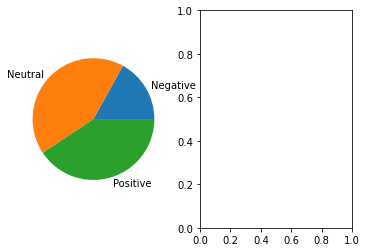

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2)

ax1.pie(sentiment.count_.values.tolist(), labels=sentiment.sentiment_label.values.tolist())

ax2.pie(sentiment2.count_.values.tolist(), labels=sentiment2.sentiment_label2.values.tolist())

# save

In [9]:
tweets.to_csv(save_to, index=False)